This notebook counts the connections of GPT models

### Load libraries

In [1]:
import math
import sys
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn

In [3]:
sys.path.append("..")
from src import utils
from src.hook_handler import HookHandler
from src.mingpt.model import CausalSelfAttention, GPT

### Get model

In [4]:
model_config = GPT.get_default_config()
model_config.model_type = 'gpt2'
model_config.vocab_size = 50257 # openai's model vocabulary
model_config.block_size = 1024  # openai's model block_size (i.e. input context length)
model = GPT(model_config)
print(f"All params: {utils.num_params(model):.2e}")

number of parameters: 124.44M
All params: 1.63e+08


In [5]:
set(c.__class__ for c in utils.get_flat_nodes(model))

{src.mingpt.model.Block,
 src.mingpt.model.CausalSelfAttention,
 src.mingpt.model.GPT,
 src.mingpt.model.NewGELU,
 torch.nn.modules.container.ModuleDict,
 torch.nn.modules.container.ModuleList,
 torch.nn.modules.dropout.Dropout,
 torch.nn.modules.linear.Linear,
 torch.nn.modules.normalization.LayerNorm,
 torch.nn.modules.sparse.Embedding}

### Count neuronal connectivity

In [18]:
def count(model, context_size: int):
    pre_counts: dict[int, int] = defaultdict(int)  # d[# pre synaptic neurons] -> count
    post_counts: dict[int, int] = defaultdict(int)  # d[# of post synaptic neurons] -> count

    for mod in utils.get_flat_nodes(model):
        match mod:

            case CausalSelfAttention():
                # Each key is compared with each query
                n_head = mod.n_head
                k_size = mod.n_embd
                v_size = mod.n_embd

                for i in range(context_size):
                    # Dot product operation
                    pre_counts[2] += (i + 1) * k_size # k * q neuron
                    post_counts[i + 1] += k_size # Key neuron for ith token
                    post_counts[context_size - i] += k_size # Query neuron for ith token

                    # Sum neurons
                    pre_counts[k_size // n_head] += (i + 1) * n_head
                    post_counts[1] += (i + 1) * k_size

                    # Multiplying with V
                    pre_counts[2] += v_size * (i + 1)
                    post_counts[context_size - i] += v_size # ith V neuron
                    post_counts[v_size // n_head] += (i + 1) * n_head # sum neurons

                    # Summing up final output for ith token
                    pre_counts[i + 1] += v_size
                    post_counts[1] += (i + 1) * v_size

            case nn.Linear():
                in_size = mod.weight.shape[1]
                out_size = mod.weight.shape[0]
                
                pre_counts[in_size] += context_size * out_size
                post_counts[out_size] += context_size * in_size

            case nn.LayerNorm():
                s, = mod.normalized_shape

                # Connections into neurons to compute averages
                pre_counts[s] += context_size
                post_counts[1] += context_size * s

            case nn.Embedding():
                # We don't count embedding layer parameters
                pass

            case _:
                pass

    return pre_counts, post_counts

In [23]:
f"{sum(k * v for k, v in count(model, context_size=2048)[0].items()):.3e}"

'3.691e+11'

### Plots

In [43]:
def gen_plot(model: nn.Module, context_size: int, model_name: str, bins: int = 40):
    pre_counts, post_counts = count(model=model, context_size=context_size)

    plt.figure(figsize=(12, 4), dpi=200)
    plt.suptitle(
        f"{model_name}-c{context_size} connectivity ({utils.num_params(model):.2e} params)"
    )
    plt.subplots_adjust(top=0.8)

    plt.subplot(1, 2, 1)
    vals, weights = zip(*[(k, v) for k, v in pre_counts.items()])
    utils.plot_loghist(vals, weights, bins=bins)
    plt.yscale("log")
    plt.ylabel("# of neurons")
    plt.xlabel("# pre-synaptic neighbors")
    plt.title(
        "\n".join(
            (
                f"# pre-synapses: {sum(k * v for k, v in pre_counts.items()):.2e}",
                f"# neurons with pre-synaptic neighbor:  {sum(pre_counts.values()):.2e}",
                f"max # of pre-synaptic neighbors:  {max(pre_counts.keys())}",
            )
        ),
        fontsize=10,
    )

    plt.subplot(1, 2, 2)
    vals, weights = zip(*[(k, v) for k, v in post_counts.items()])
    utils.plot_loghist(vals, weights, bins=bins)
    plt.yscale("log")
    plt.ylabel("# of neurons")
    plt.xlabel("# post-synaptic neighbors")
    plt.title(
        "\n".join(
            (
                f"# post-synapses: {sum(k * v for k, v in post_counts.items()):.2e}",
                f"# neurons with post-synaptic neighbor: {sum(post_counts.values()):.2e}",
                f"max # of post-synaptic neighbors: {max(post_counts.keys())}",
            )
        ),
        fontsize=10,
    )

number of parameters: 123.66M


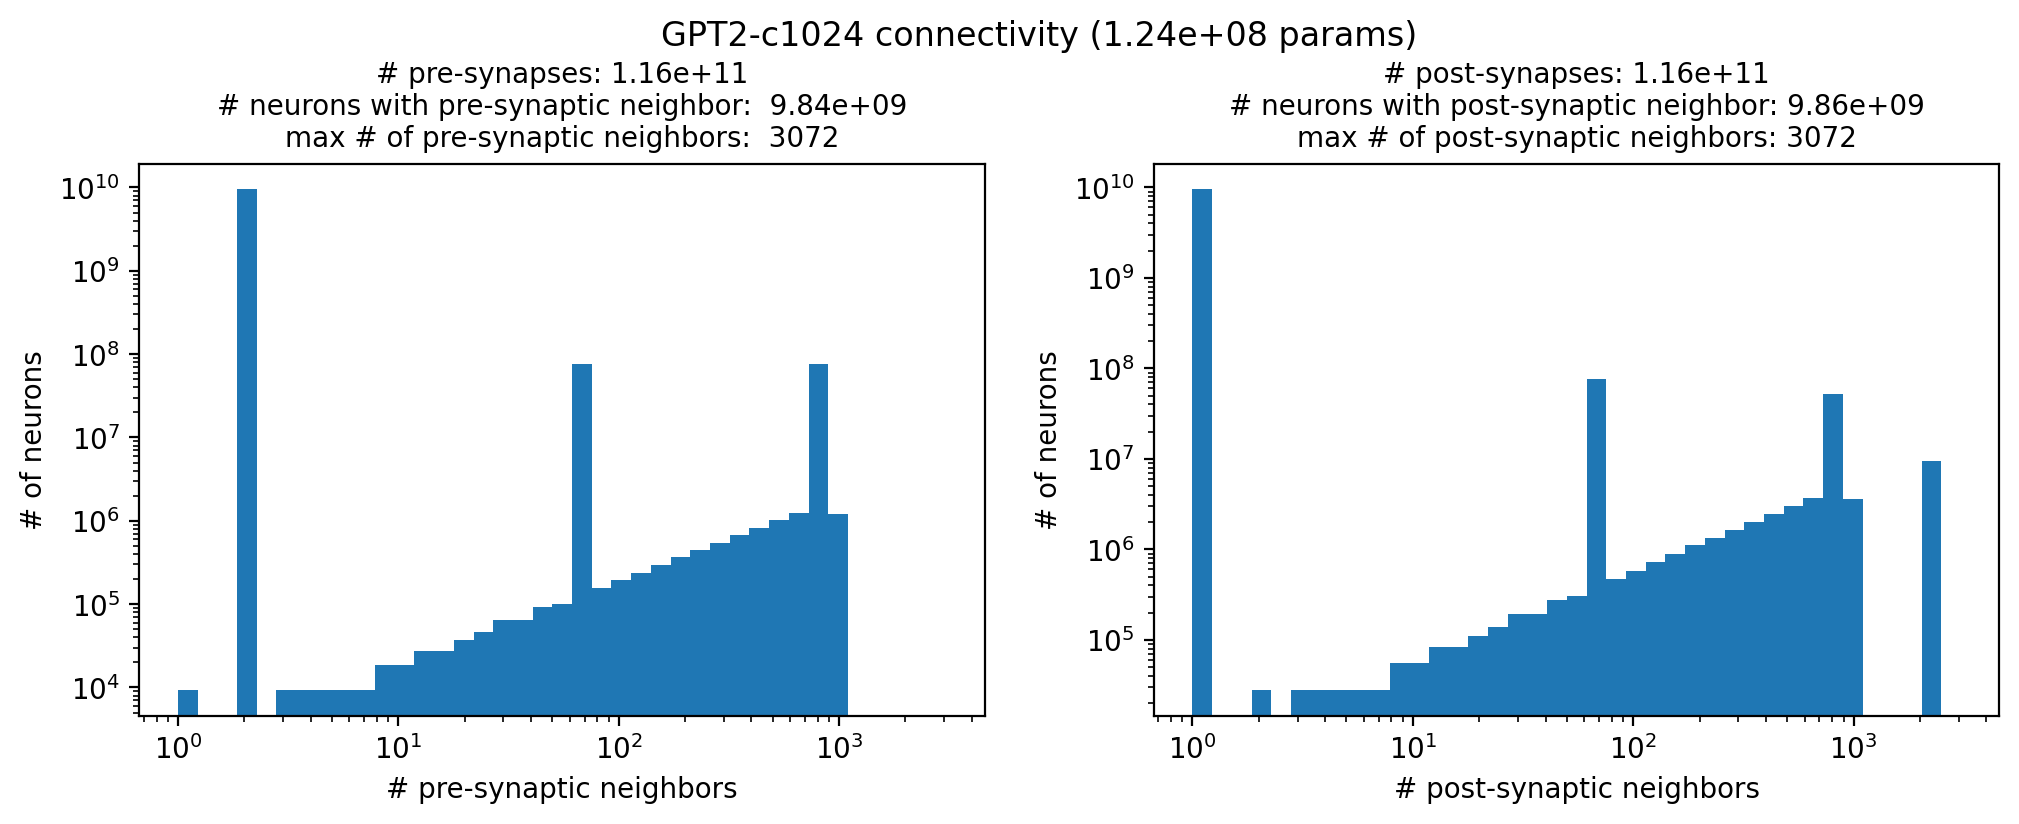

In [47]:
context_size = 1024
model_config = GPT.get_default_config()
model_config.model_type = 'gpt2'
model_config.vocab_size = 50257 # openai's model vocabulary
model_config.block_size = 10 # Frozen at small value that doesn't matter
gpt2 = GPT(model_config)
gpt2.lm_head = None # Remove output head
gen_plot(model=gpt2, context_size=context_size, model_name="GPT2")

number of parameters: 174579.22M


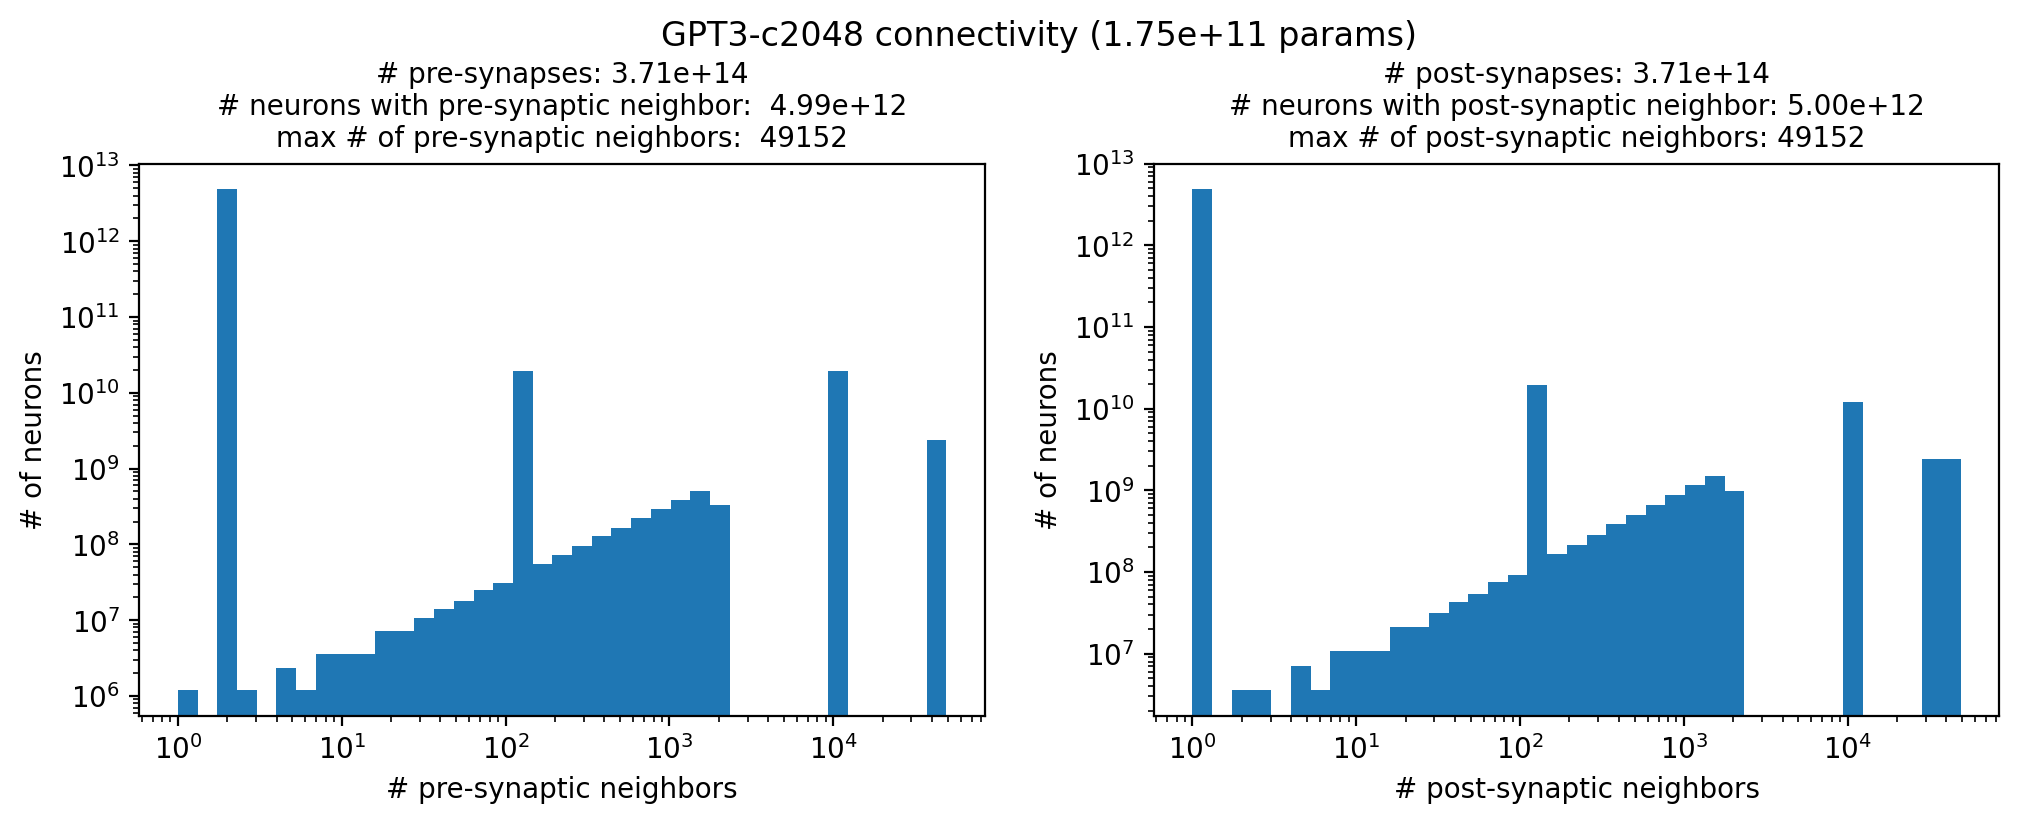

number of parameters: 174579.22M


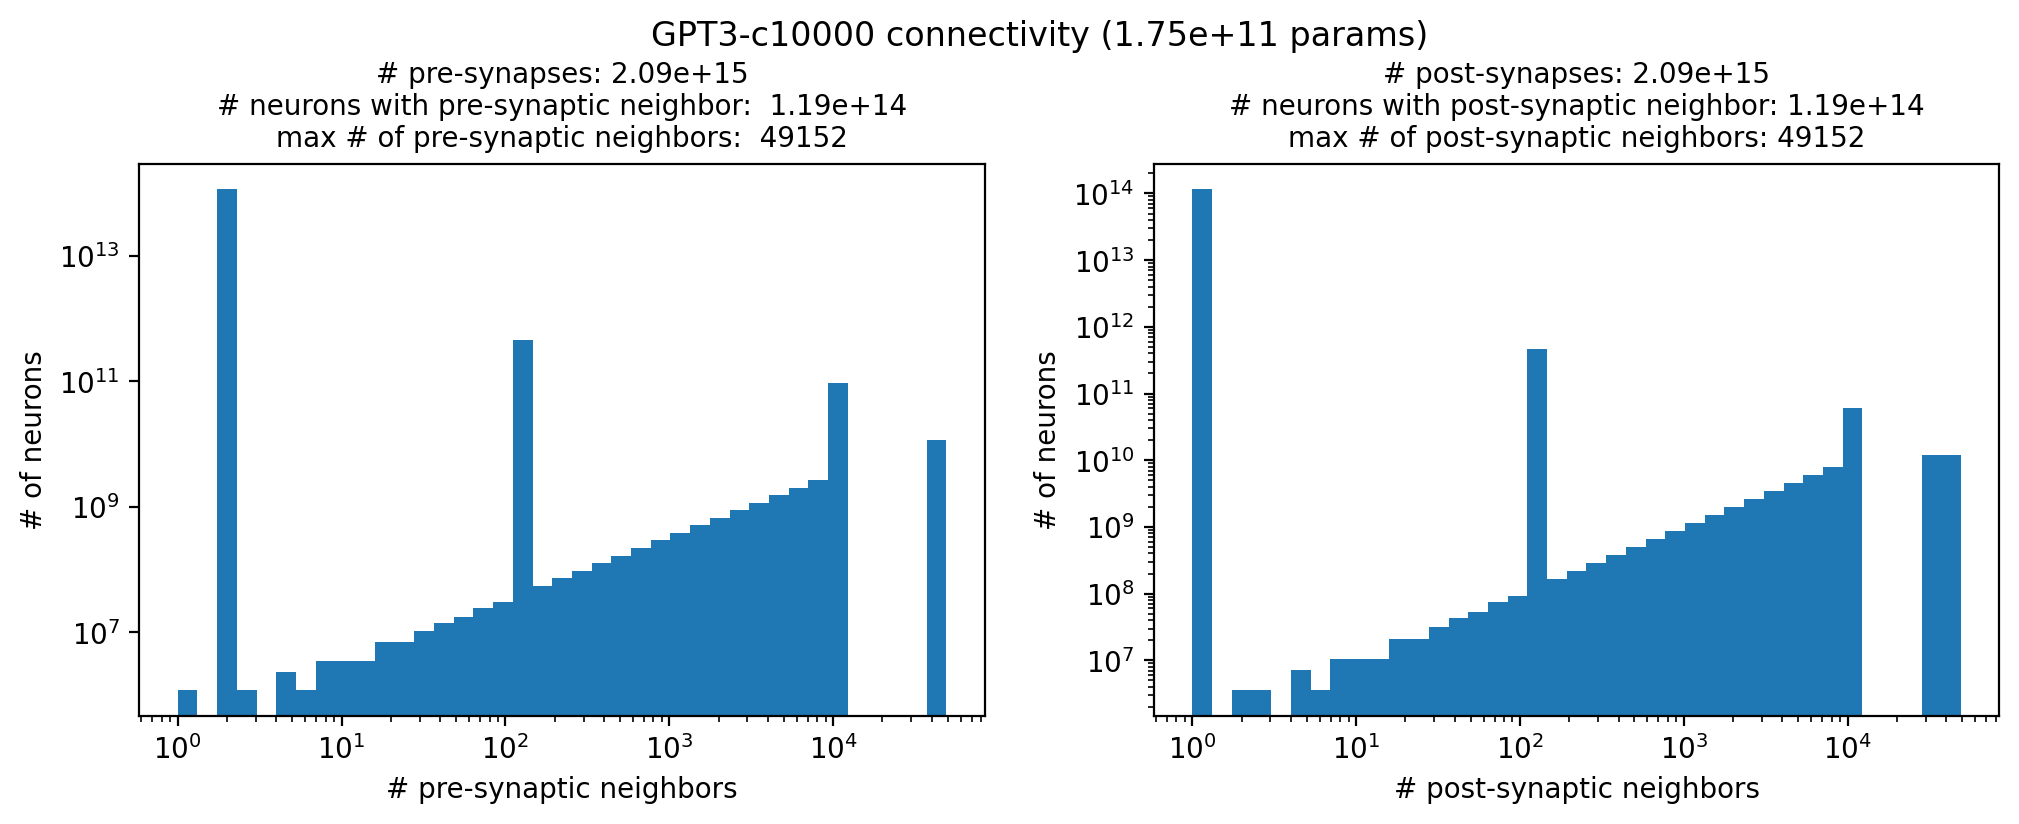

number of parameters: 174579.22M


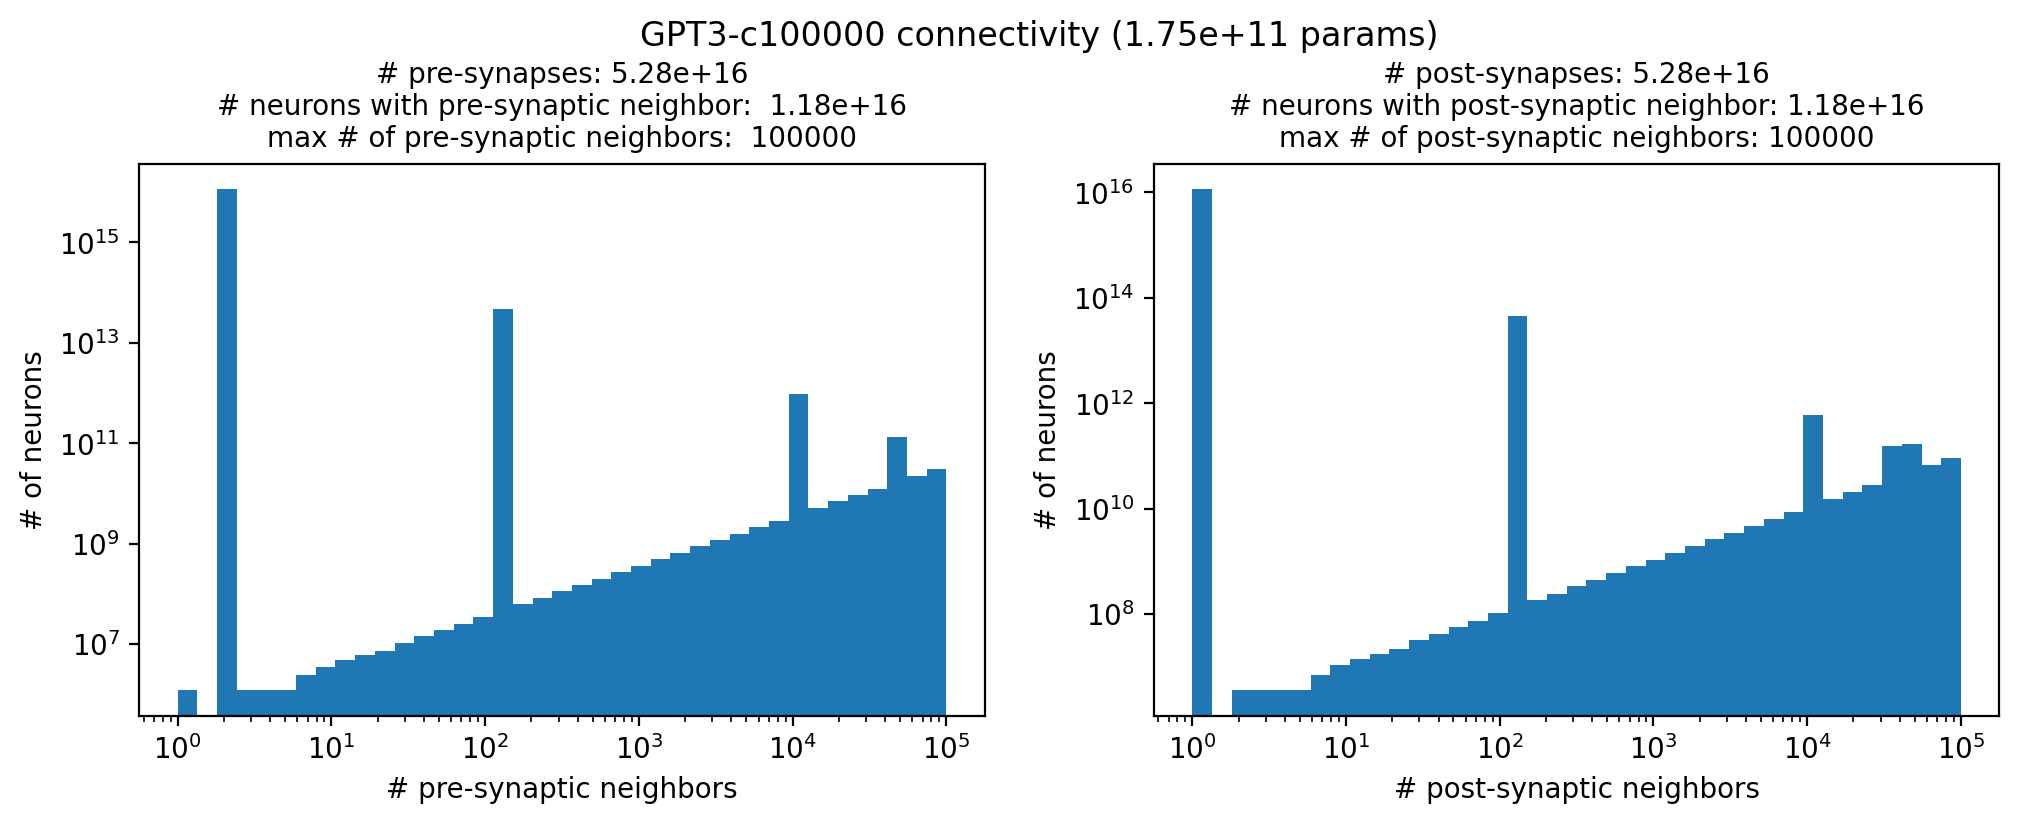

number of parameters: 174579.22M


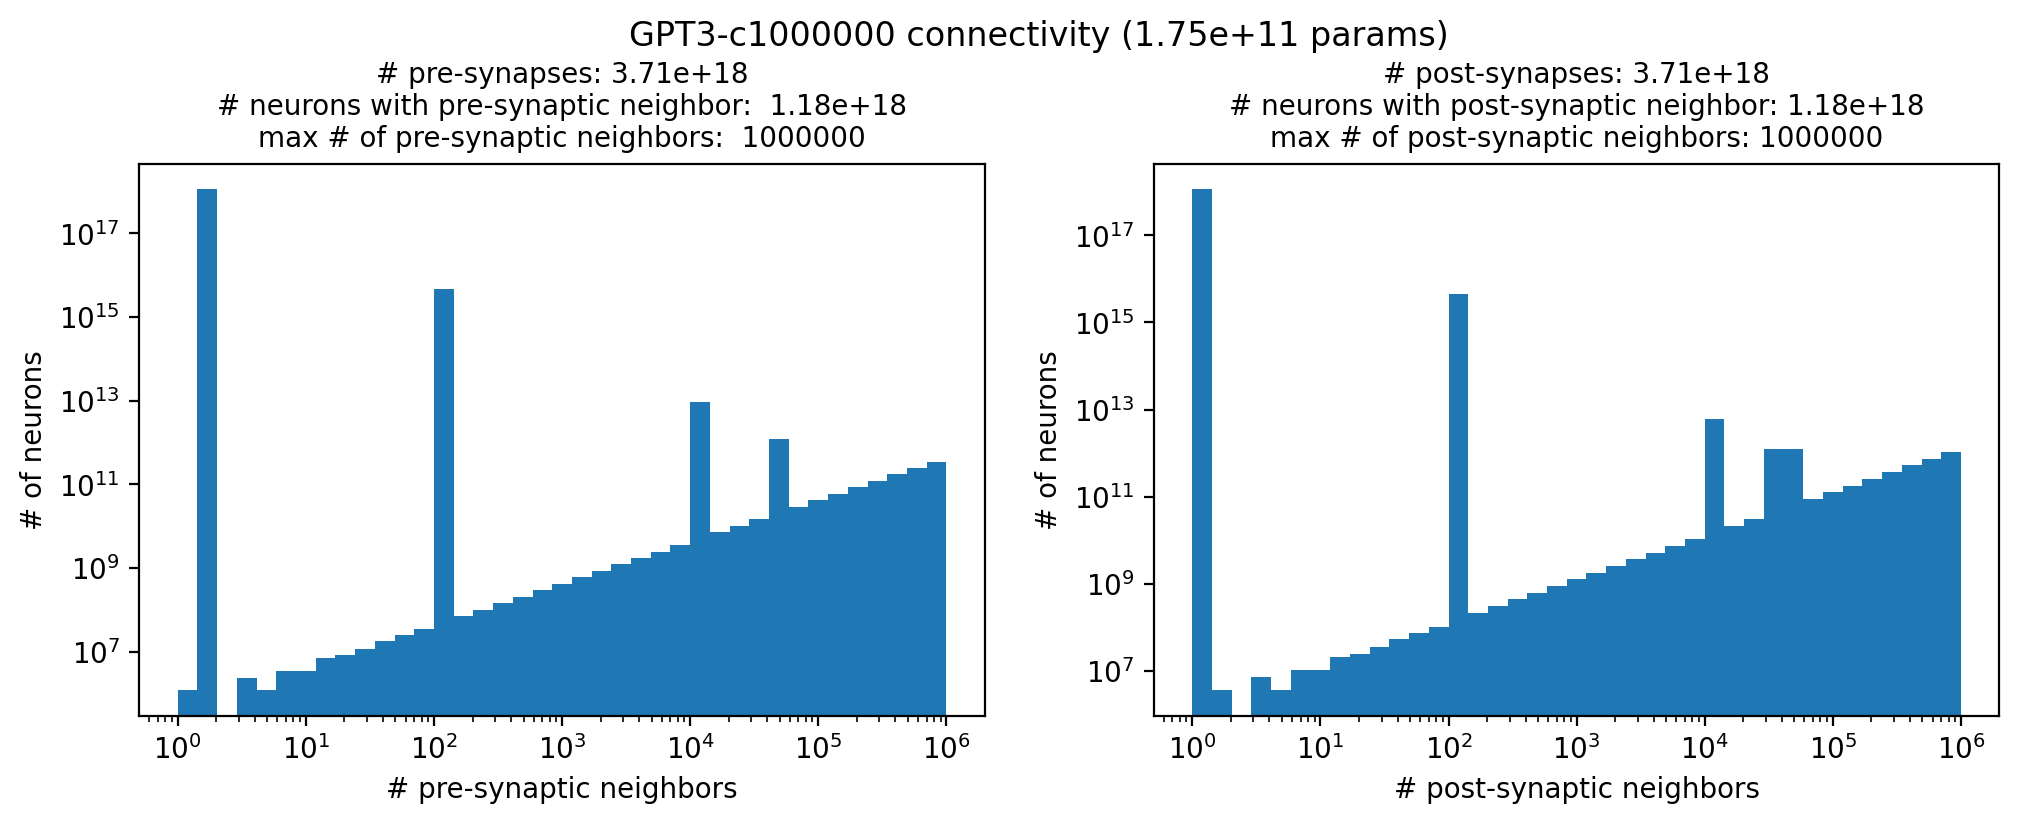

In [48]:
for context_size in [2048, 10_000, 100_000, 1_000_000]:
    model_config = GPT.get_default_config()
    model_config.model_type = None
    model_config.n_layer = 96
    model_config.n_head = 96
    model_config.n_embd = 12288
    model_config.vocab_size = 50257 # openai's model vocabulary
    model_config.block_size = 10 # Frozen at small value that doesn't matter
    gpt3 = GPT(model_config)
    gpt3.lm_head = None # Remove output head
    gen_plot(model=gpt3, context_size=context_size, model_name="GPT3")
    plt.show();